# CSE 6240 - Web Search & Text Mining - Project 2

In [1]:
# __author__ = 'Bhanu Verma', 'Nilaksh Das'
# GTid = '903151012', '903129996'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import os, os.path
from PIL import Image
from pylab import *
import random
from sklearn.linear_model import orthogonal_mp
from scipy.sparse import csc_matrix
import time
from matplotlib.pyplot import imshow
from PIL import Image
import PIL.ImageOps
%matplotlib inline

In [3]:
categoryArr = []
animalPath = 'Data/Animal'
fungusPath = 'Data/Fungus'
geoPath = 'Data/Geological Formation'
personPath = 'Data/Person'
plantPath = 'Data/Plant, flora, plant life'
sportPath = 'Data/Sport'

# animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
categoryArr = [animalPath]

In [4]:
def ksvd(Y, K, T, D=None, max_err=0, max_iter=10, approx=False,preserve_dc=False):
    (N, M) = Y.shape

    if D is None:
        D = rand(N, K)
        # D /= np.linalg.norm(D,axis = 0)
        
    # normalize dictionary
    for i in range(K):
        D[:,i] /= norm(D[:,i])
        
#     print("running ksvd on ", M, " ", N, "- dimensional vectors with K=", K)
    
    X = zeros((K,N))
    err = inf
    iter_num = 0
    
    while iter_num < max_iter and err > max_err:
        X = orthogonal_mp(D, Y, T, max_err)

#         print('average l0 norm for ksvd iteration ', iter_num, ' after omp was ', (iter_num, len(nonzero(X)[0])/M))

        atom_indices=[]
        for x in range(K):
            atom_indices.append(x)
        # atom_indices = range(K)
    
        random.shuffle(atom_indices)

        unused_atoms = []

        for (i, j) in zip(atom_indices, range(K)):
            # find nonzero entries
            x_using = nonzero(X[i,:])[0]
        
            if len(x_using) == 0:
                unused_atoms.append(i)
                continue

            X[i,x_using] = 0
            Residual_err = Y[:,x_using] - dot(D,X[:,x_using])

            # update dictionary and weights -- sparsity-restricted rank-1
            # approximation
            U, s, Vt = svd(Residual_err)
            D[:,i] = U[:,0]
            X[i,x_using] = s[0]*Vt.T[:,0]

        Repr_err = Y - dot(D,X)
        Repr_err_norms = ( norm(Repr_err[:,n]) for n in range(M) )

        err_indices = sorted(zip(Repr_err_norms, range(M)), reverse=True)

        for (unused_index, err_tuple) in zip(unused_atoms, err_indices):
            (err, err_idx) = err_tuple

            d = Y[:,err_idx].copy()
            if preserve_dc: 
                d -= mean(d)
            d /= norm(d)
            D[:,unused_index] = d


        Repr_err_norms = [norm(Repr_err[:,n]) for n in range(M)]
        err = max(Repr_err_norms)

        iter_num += 1

#         print("maximum representation error for ksvd iteration ", iter_num, " was ", (iter_num, err))
    
    return D,X

In [5]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
start_time = time.time()

D_list = []
X_list = []
index_to_name = {}
name_to_index = {}
count  = 0

for a,category in enumerate(categoryArr):
    dirList = os.listdir(category)

    for i,fname in enumerate(dirList):
        if i >= 5:
            break
        img_path = category+'/'+fname
        img = Image.open(img_path)
        img_size = tuple([int(x) for x in img.size])
        img = img.resize(img_size)
        img = img.convert('L')
        img_arr = np.array(img)
        img_arr = img_arr/255.0
            
        try:
            D,X = ksvd(img_arr, 100, None, D=None, max_err=0, max_iter=10, approx=False, preserve_dc=True)
        except:
            print("SVD error")
            D = 'Error'
            X = 'Error'
        
        D_list.append(D)
        X_list.append(X)
        index_to_name[count] = img_path
        name_to_index[img_path] = count
        
        print("k-svd run for image ", count)
        count += 1
        
print("Time taken: ",(time.time() - start_time)/float(60.0), ' minutes')
        

k-svd run for image  0
k-svd run for image  1
k-svd run for image  2
k-svd run for image  3
k-svd run for image  4
Time taken:  11.067327149709065  minutes


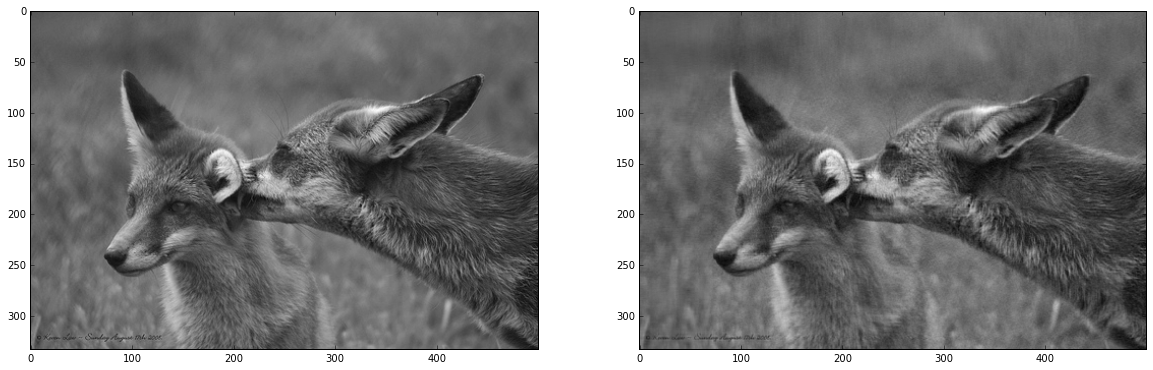

33.93998295907138


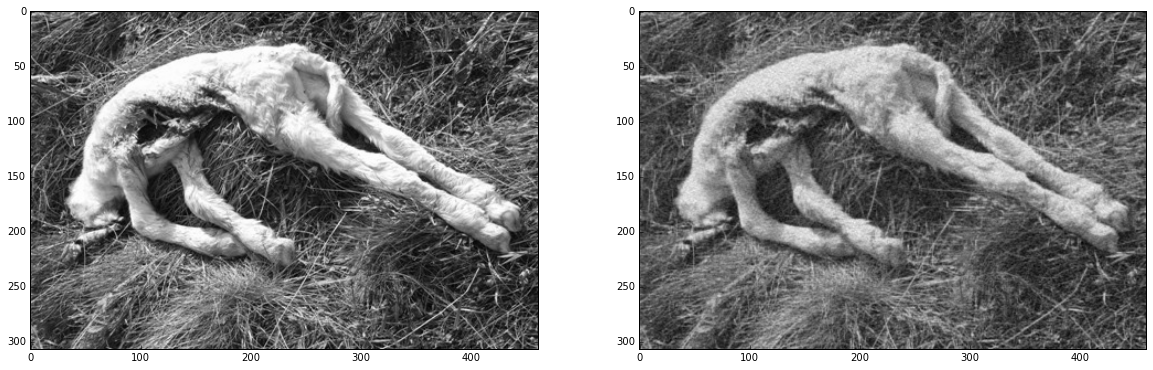

24.58453329438006


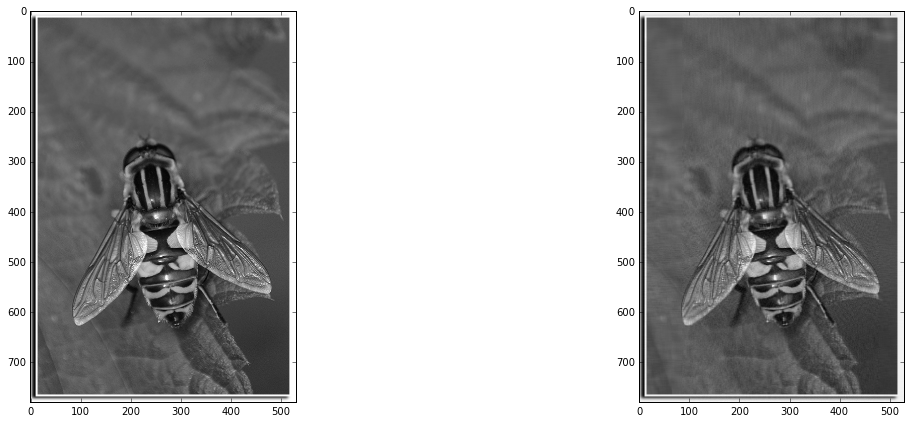

34.08278698680748


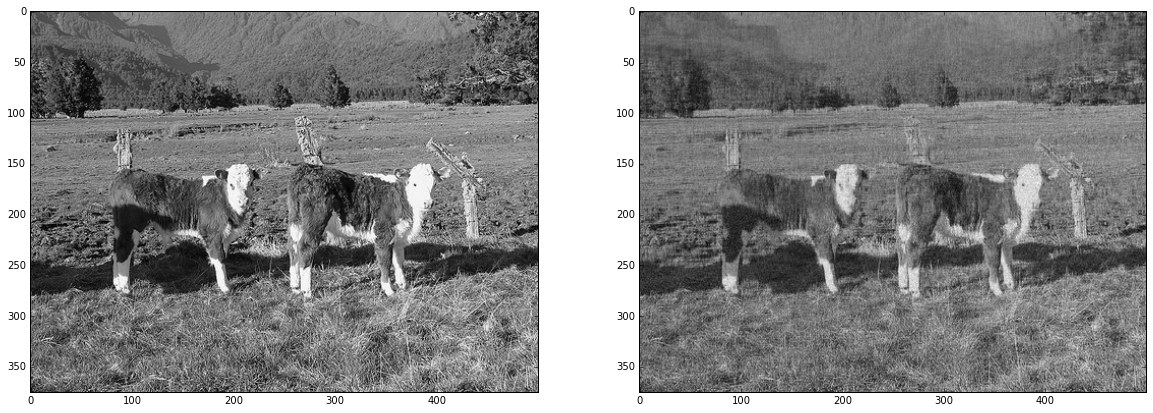

21.9988124462376


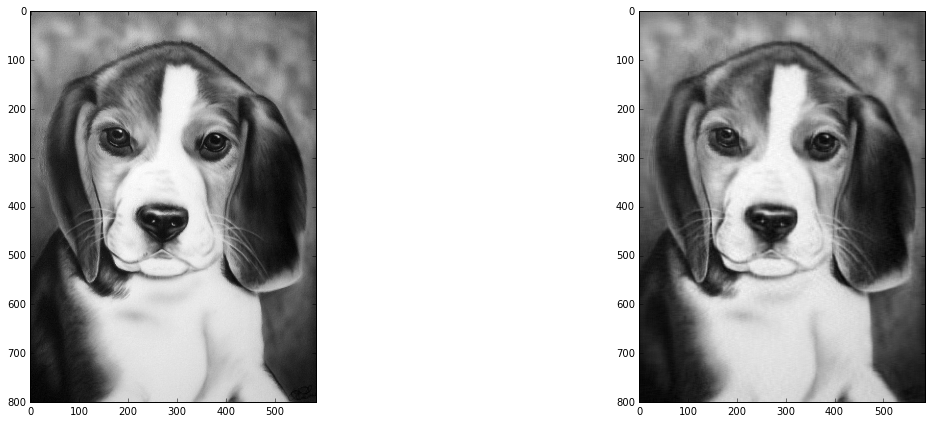

37.54873334712156


In [32]:
for a,category in enumerate(categoryArr):
    dirList = os.listdir(category)

    for i,fname in enumerate(dirList):
        if i >= 5:
            break
        
        D = D_list[i]
        X = X_list[i]
        
        if D == 'Error' or X == 'Error':
            print('Error Occurred')
        else:
            plt.figure(i, figsize=(20, 7))

            plt.subplot(1,2,1)
            name = index_to_name[i]
            before = Image.open(name)
            before = before.convert('L')
            before = np.array(before)
            imshow(before, cmap = plt.get_cmap('gray'))

            plt.subplot(1,2,2)
            after = dot(D,X)
            after = after * 255.0
            imshow(after, cmap = plt.get_cmap('gray'))

            plt.show()

            print(psnr(np.asarray(before),after))
